Project 1: Introduction to Deep Learning
===

___

Submitted by:

* <u>*Arthur Humblot*</u>
* <u>*Bekhzod Anvarov*</u>
* <u>*Ghita El Belghiti*</u>

University: **Politechnico di Torino**

Academic Year: **2025 - 2026**

## 1. Task 1: Data Preprocessing

The goal of this section is to make sure our set of data can be used efficiently by our FNN. First we will remove the Nan data and duplicate data.
We set a random seed than we delete the missing and duplicates values from our dataset in the same way of the document notebook 1-FFNN of the courses.

In [30]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

import time

### 1.1 Remove missing values (NaN) and duplicate entries.

Q: How many samples did you have before and after removing missing and duplicates entries?

In [31]:
# Set random seed for reproducibility
random_seed = 42      # 42 - common practice
np.random.seed(random_seed)

# Open the dataset
data = pd.read_csv("dataset_lab_1.csv")
print(f"Number of rows in our dataset: {data.shape[0]}")

# After detecting of +-inf values on dataset, they are replaced with Nan(to remove after)
# Replacing +-infinite values with Nan
data = data.replace([np.inf, -np.inf], np.nan)

# Remove rows with missing values
data = data.dropna()
print(f"Number of rows after missing values: {data.shape[0]}")

# Remove duplicates
data = data.drop_duplicates()
print(f"Number of rows after duplicates: {data.shape[0]}")

# Encode labels
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

Number of rows in our dataset: 31507
Number of rows after missing values: 31480
Number of rows after duplicates: 29386


### 1.2 Split the dataset to extract a training, validation and test sets (60%, 20%, 20%).

* Remember to set the seeds if you want reproducibility.
* Focus on the training and validation partitions
* Check for the presence of outliers and decide on the correct normalization

Q: How did you normalize the data? Why did you choose it?

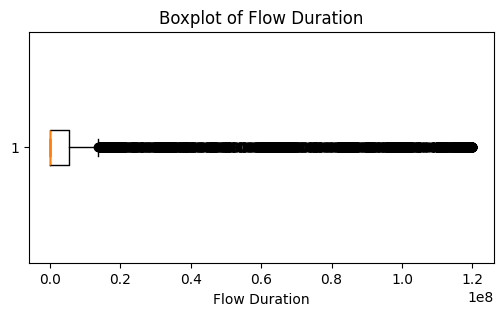

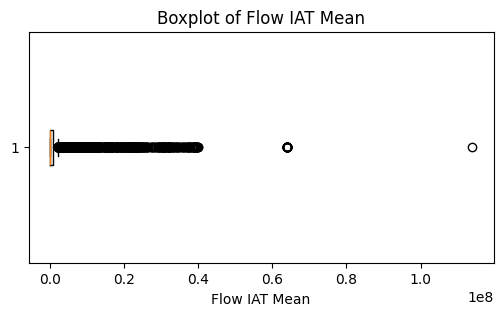

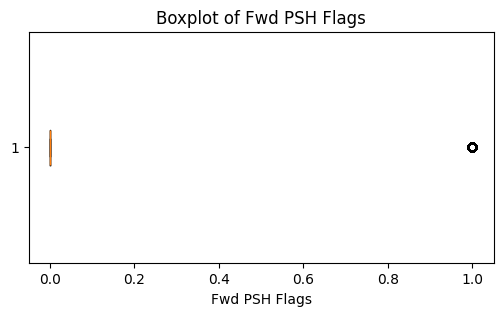

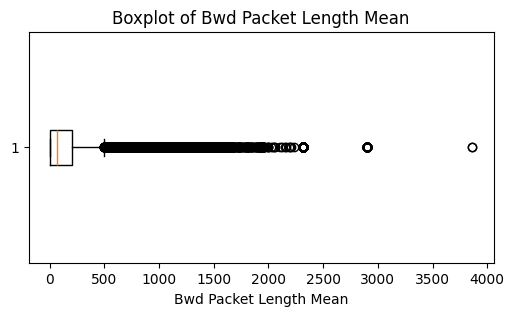

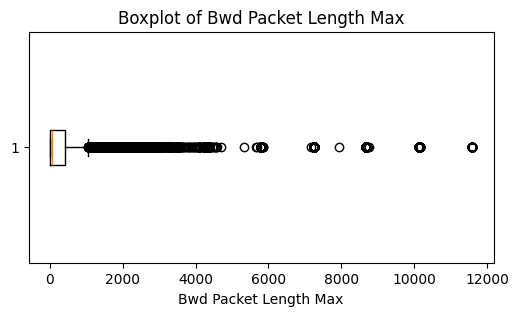

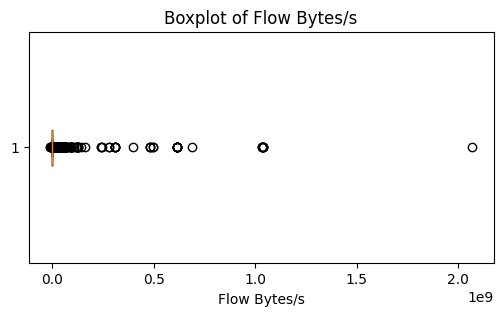

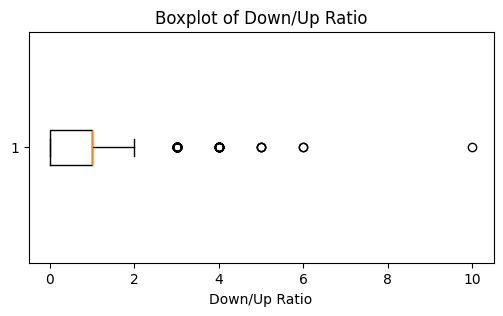

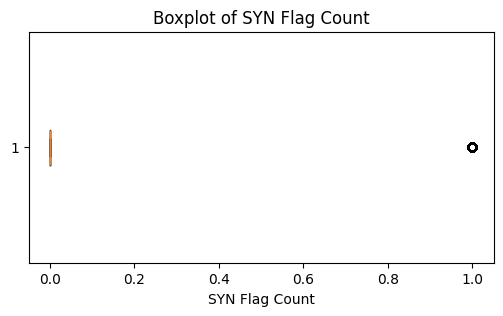

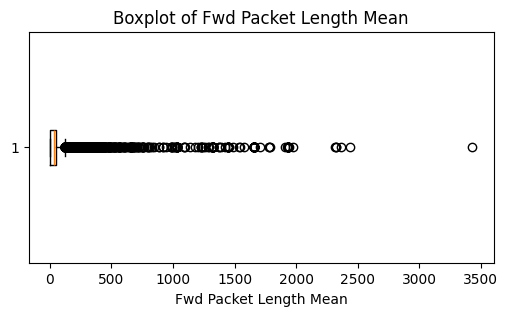

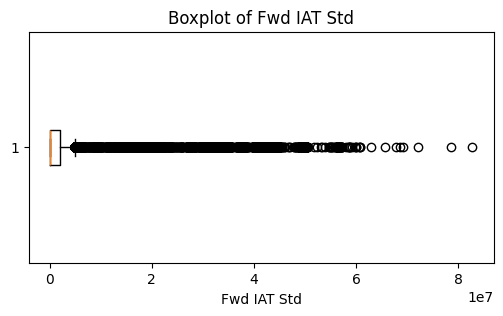

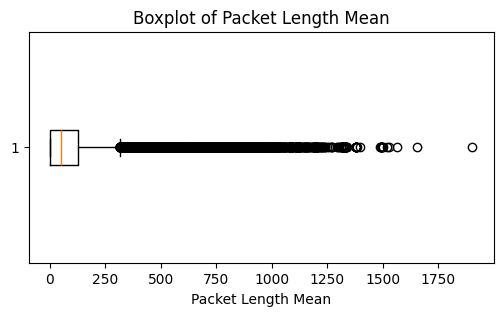

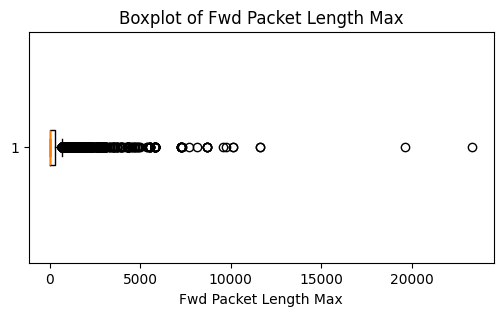

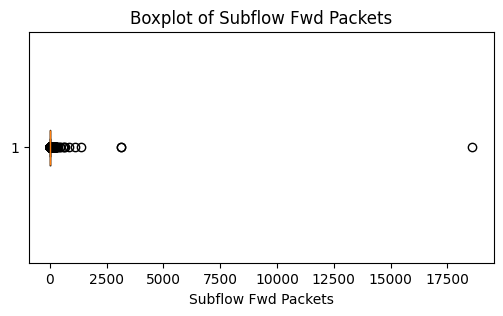

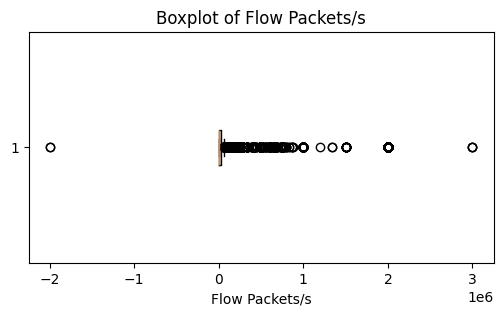

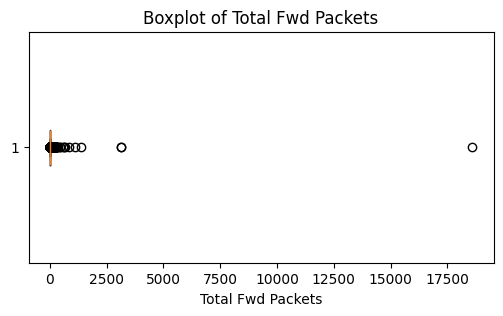

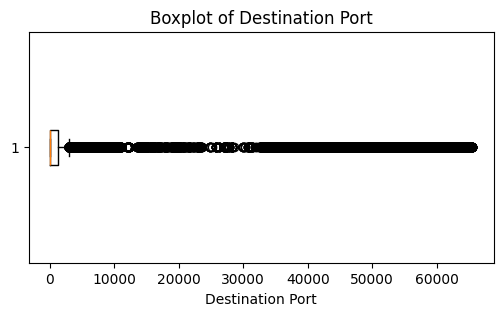

In [32]:
# To verify the presence of outliers we can visualize the data on matplotlib

numerical_cols = data.select_dtypes(include='number').columns

for col in numerical_cols[:-1]:
    plt.figure(figsize=(6,3))
    plt.boxplot(data[col], vert=False)  # vert=False pour horizontal
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [33]:
# Split to features in X and label in y
X = data.drop(columns=['Label']).values
y = data['Label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Standardize the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## 2. Task 2: Shallow Neural Network
 Design your first Neural Network.

### 2.1 Model

In [34]:
class ShallowNN(nn.Module):
    """
    Args:
        input_size: feature size of the neural network
        hidden_size: hidden layer size
        output_size: label size of the neural network
        activation: activation function, default is None which means linear('linear') or Relu as 'relu'
        use_batch_norm: use batch normalization, default is False
        dropout: dropout rate, default is 0.0
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int,
                 activation: Optional[str] = None,
                 use_batch_norm: bool = False,
                 dropout: float = 0.0):
        super(ShallowNN, self).__init__()

        layers: list = [nn.Linear(input_size, hidden_size)]

        if use_batch_norm:
            layers.append(nn.BatchNorm1d(hidden_size))

        if activation.lower() == "relu":
            layers.append(nn.ReLU())

        if dropout > 0.0:
            layers.append(nn.Dropout(p=dropout))

        layers.append(nn.Linear(hidden_size, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

#### 2.1.1 Device choice by availability

* CPU
* GPU (CUDA)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {str(device).upper()}")

Device: CUDA


### 2.2 Training Loop

In [36]:
def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs = 100, min_delta: Optional[float] = None, patience: int = 5):
    """
    Train the model for a specified number of epochs and track the training and validation losses.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.
        min_delta: early stopping delta value
        patience: number of epochs to wait before early stopping.
        num_epochs: maximum number of epochs

    Returns:
        Tuple: of -> trained mode, train & val losses
    """
    # Record the start time
    start_time = time.time()

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    trigger_times = 0     # how many epochs since last improvement
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
                val_outputs = model(batch_X)  # Forward pass
                loss = criterion(val_outputs, batch_y)  # Compute validation loss
                val_loss += loss.item() * batch_X.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        # Early Stopping
        if min_delta is not None:
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')
    return model, train_losses, val_losses


def testing_model(model, dataloader, device):
    """
    Evaluate the model on a given dataloader and compute accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Print classification report
    print("\nClassification Report per class:")
    print(classification_report(all_labels, all_predictions, digits=4, zero_division=0))

    # Record the end time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy

def testing_models(models, device, test_loader):
    for model in models:
        accuracy = testing_model(model[0], test_loader, device)
        print(accuracy)

### 2.3 Useful utilities

In [37]:
def plot_models(models):
    plt.figure(figsize=(10, 6))
    for i, (model, train_loss, val_loss) in enumerate(models, start=1):
        plt.plot(train_loss, label=f"Train model {i}")
        plt.plot(val_loss, label=f"Val model {i}", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.show()

def prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size = 64):
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader


def train_model(model, train_loader, val_loader,  train_dataset, val_dataset, device, optimizer, num_epochs = 100, patience=5):
    # parameters for training
    criterion = nn.CrossEntropyLoss()

    #Launch the training_loop
    trained_model, train_loss, val_loss = training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience)

    #Add the model to our list of model to compare parameters
    return model, train_loss, val_loss

def train_model_with_balancement(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs = 100, patience=5):

    # parameters for training
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    class_weights_tensor = class_weights_tensor.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    #Launch the training_loop
    trained_model, train_loss, val_loss = training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience)

    #Add the model to our list of model to compare parameters
    return model, train_loss, val_loss

def train_model_with_balancement_seconde_version(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs = 100, patience=5):

    # parameters for training
    class_counts = np.bincount(y_train)
    alpha = 0.5
    class_weights = (1.0 / class_counts) ** alpha
    class_weights = class_weights / class_weights.sum()
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    class_weights_tensor = class_weights_tensor.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    #Launch the training_loop
    trained_model, train_loss, val_loss = training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, num_epochs, patience)

    #Add the model to our list of model to compare parameters
    return model, train_loss, val_loss

def test_plot_models(models, device, test_loader):
    testing_models(models, device, test_loader)
    plot_models(models)

Plot the loss curves during training on the training and validation set of the three models.
What is their evolution? Do they converge?
* How do you select the best model across epochs?
* Focus and report the classification reports of the validation set of the three models.

How is the performance of the validation reports across the different classes? Is the
performance good or poor? Why?
* Now, focus on the best model you chose. Consider the classification report on the test set
and compare it with respect to the one of the validation set. Is the performance similar?
I.e., does the model generalize?

* Focus and report the classification report of the validation set. Does the model perform
better in a specific class?
* Would it be correct to compare the results on the test set?

In [38]:
def activity_one(architectures, train_loader, val_loader, train_dataset, val_dataset, test_loader, device, activation="linear"):
    models = []
    for architecture in architectures:
        model = ShallowNN(*architecture, activation=activation).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        models.append(train_model(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer))

    test_plot_models(models, device, test_loader)

input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 32, output_len], [input_len, 64, output_len], [input_len, 128, output_len]]

#test_loader
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor)
activity_one(architectures, train_loader, val_loader, train_dataset, val_dataset, test_loader, device, activation="linear")

Early stopping at epoch 6 (best val loss: 0.735571)
The function took 2.0242 seconds to execute.
Early stopping at epoch 6 (best val loss: 0.573069)
The function took 1.7823 seconds to execute.
Early stopping at epoch 6 (best val loss: 0.506323)
The function took 1.8493 seconds to execute.


AttributeError: 'tuple' object has no attribute 'eval'

In [ ]:
activity_one(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="relu")

## 3. Task 3: The impact of Specific Features

Is this a reasonable assumption?
* Replace port 80 with port 8080 for the Brute Force attacks in the Test set.

Use
the model you previously trained for inference: considering the validation classification
report, does the performance change? How does it change? Why?

In [ ]:
# Split label in var Y and features in X
X = data.drop(columns=['Label']).values
y = data['Label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

#Modify only X_test
label_bruteforce = list(label_encoder.classes_).index("Brute Force")
mask_test  = (y_test == label_bruteforce)

X_test[mask_test][X_test[mask_test] == 80] = 8080

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 128, output_len]]

# Same test as before after changing the port on Brute Force attack
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor)
activity_one(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="relu")

How many PortScan do you now have after preprocessing (e.g., removing duplicates)?

How many did you have before?
* Why do you think PortScan is the most affected class after dropping the duplicates?
* Are the classes now balanced?

In [ ]:
data = pd.read_csv("dataset_lab_1.csv")

# Count PortScan BEFORE preprocessing
portscan_before = data[data["Label"] == "PortScan"].shape[0]
print("PortScan count before preprocessing:", portscan_before)
print("Number of rows in the raw dataset:", len(data))

# Replace infinite values
data = data.replace([np.inf, -np.inf], np.nan)

# Drop missing values
data = data.dropna()

# Drop duplicates (first pass)
data = data.drop_duplicates()
print("Number of rows after removing missing values and duplicates:", len(data))

# Count PortScan after first duplicate removal
portscan_after_first = data[data["Label"] == "PortScan"].shape[0]
print("PortScan count after first duplicate removal:", portscan_after_first)

# Remove Destination Port and drop duplicates again
print("Rows before removing Destination Port column:", len(data))
data = data.drop(columns=["Destination Port"])
data = data.drop_duplicates()
print("Rows after removing duplicates (final):", len(data))

# Count PortScan AFTER final preprocessing
portscan_after = data[data["Label"] == "PortScan"].shape[0]
print("PortScan count after full preprocessing:", portscan_after)

class_counts = data["Label"].value_counts()
print("\nClass distribution after preprocessing:\n", class_counts)

label_encoder = LabelEncoder()
data["Label"] = label_encoder.fit_transform(data["Label"])

X = data.drop(columns=["Label"]).values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 128, output_len]]

# Same test as before after changing the port on Brute Force attack
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor)
activity_one(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="relu")

## 4. Task 4: The impact of the Loss Function

* How does the performance change? Can you still classify the rarest class?
* Which partition do you use to estimate the class weights?

Now, repeat the training process with the new loss:
* How does the performance change per class and overall? In particular, how does the accuracy change? How does the f1 score change?

In [ ]:
def activity_one_with_weight(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="linear"):
    """
    Same as activity one but with a weight
    """
    models = []
    for architecture in architectures:
        model = ShallowNN(*architecture, activation=activation).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        models.append(train_model_with_balancement(model, train_loader, val_loader, train_dataset, val_dataset, optimizer))

    test_plot_models(models)

def activity_one_with_weight_v2(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="linear"):
    """
    Same as activity one but with another weight version.
    """
    models = []
    for architecture in architectures:
        model = ShallowNN(*architecture, activation=activation).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        models.append(train_model_with_balancement_seconde_version(model, train_loader, val_loader, train_dataset, val_dataset, optimizer))

    test_plot_models(models)

input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 128, output_len]]

# Same test as before after changing the port on Brute Force attack
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor)
activity_one_with_weight(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="relu")
activity_one_with_weight_v2(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="relu")

## 5. Task 5: Deep Neural Network

Now extend the architecture by adding multiple layers to design your first Deep Learning
architecture.

In [ ]:
input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [
    [input_len, 8, 4, 2, output_len],
    [input_len, 32, 16, 8, output_len],
    [input_len, 16, 8, 4, 2, output_len],
    [input_len, 32, 16, 8, 4, output_len],
    [input_len, 32, 16, 8, 4, 2, output_len],
    [input_len, 32, 32, 16, 8, 4, output_len]
]

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor)
activity_one(architectures, train_loader, val_loader, train_dataset, val_dataset, device, activation="relu")

### 5.2 The impact of Batch Size

In [ ]:
batch_sizes = [4, 64, 256, 1024]
best_architecture = [input_len, 32, 16, 8, 4, output_len]   #set after the previous experimentation

def activity_two(architecture, batch_sizes, device, num_epochs = 50, activation="relu"):
    models = []
    for batch_size in batch_sizes:
        model = ShallowNN(*architecture, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size=batch_size)
        models.append(train_model(model, train_loader, val_loader, train_dataset, val_dataset, optimizer, num_epochs=num_epochs))

    test_plot_models(models, device)

activity_two(best_architecture, num_epochs = 100, batch_sizes=batch_sizes, activation="relu")

### 5.3 The impact of the Optimizer

* Is there a difference in the trend of the loss functions?
* How long does it take to train the models with the different optimizers? And why?

Now, focus on the architecture with the best optimizer.
* Evaluate the effects of the different learning rates and epochs. Report the test results for the best model.

In [ ]:
best_batchsize = 64
optimizers = [lambda params: optim.SGD(params, lr=0.0005), lambda params: optim.SGD(params, lr=0.0005, momentum=0.1), lambda params: optim.SGD(params, lr=0.0005, momentum=0.5), lambda params: optim.SGD(params, lr=0.0005, momentum=0.9), lambda params: optim.AdamW(params, lr=0.0005)]

def activity_three(architecture, train_loader, val_loader, train_dataset, val_dataset, device, optimizers, batch_size, num_epochs = 50, activation="relu"):
    models = []
    for opt_builder in optimizers:
        model = ShallowNN(*architecture, activation=activation).to(device)
        optimizer = opt_builder(model.parameters())
        trained_model = train_model(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, num_epochs=num_epochs)
        models.append(trained_model)
    test_plot_models(models)

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, best_batchsize)
activity_three(best_architecture, train_loader, val_loader, train_dataset, val_dataset, device, optimizers, num_epochs=100, activation="relu")

In [ ]:
optimizers = [lambda p, lr=lr: optim.AdamW(p, lr=lr) for lr in [0.01, 0.005, 0.001, 0.0005, 0.0001]]
train_dataset, val_dataset, test_dataset ,train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, best_batchsize)
activity_three(best_architecture, train_loader, val_loader, train_dataset, val_dataset, device, optimizers, num_epochs=100, activation="relu")

## 6. Task 6: Overfitting and Regularization
* What do the losses look like? Is the model overfitting?

Now apply normalization techniques (dropout, batch normalization) and play with the regularization of the weights (AdamW’s weight decay).
* What impact do the different normalization techniques have on validation and testing performance?

In [ ]:
# Define Deep Feed Forward NN
class DeepFFNN(nn.Module):
    """
    Args:
        input_size: feature size of the neural network
        hidden_sizes: list of hidden layers sizes
        output_size: label size of the neural network
        use_batch_norm: whether to use batch normalization
        dropout: dropout rate, default is 0.0
    """
    def __init__(self, input_size: int, hidden_sizes: list[int], output_size: int, use_batch_norm: bool = False, dropout: float = 0.0):
        super(DeepFFNN, self).__init__()

        layers = []
        tmp = input_size

        if len(hidden_sizes) == 0:
            layers.append(nn.Linear(input_size, output_size))

        else:
            for i in hidden_sizes:
                layers.append(nn.Linear(tmp, i))
                if use_batch_norm: layers.append(nn.BatchNorm1d(i))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
                tmp = i

            layers.append(nn.Linear(tmp, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [ ]:
def task_6():

    models = list()

    # data prep loader
    train_dataset, val_dataset, _, train_loader, val_loader, _ = prep_loader(X_train_tensor, y_train_tensor,
                                                                             X_val_tensor, y_val_tensor, X_test_tensor,
                                                                             y_test_tensor, batch_size=128)

    # Loss
    criterion = nn.CrossEntropyLoss()

    # model #1 - without regularization
    model_1 = DeepFFNN(input_len, [256, 128, 64, 32, 16], output_len)
    optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.0005)
    trained_model1 = train_model(model_1, train_loader, val_loader, train_dataset, val_dataset, device, optimizer_1, num_epochs=50)
    models.append(trained_model1)

    # model #2 with regularization
    model_2 = DeepFFNN(input_len, [256, 128, 64, 32, 16], output_len, use_batch_norm=True, dropout=0.1)
    optimizer_2 = optim.AdamW(model_2.parameters(), lr=0.0005)
    trained_model2 = train_model(model_2, train_loader, val_loader, train_dataset, val_dataset, device, optimizer_2,
                                 num_epochs=50)
    models.append(trained_model2)
    test_plot_models(models)

task_6()